In [13]:
import yfinance as yf
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score

<AxesSubplot:xlabel='Date'>

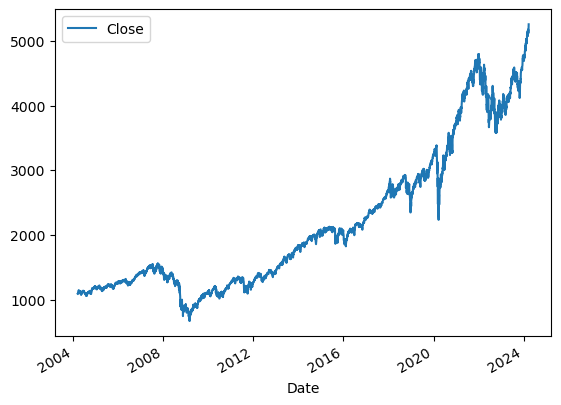

In [5]:
sp500 = yf.Ticker('^GSPC').history(period='20y', interval="1d")[['Close', 'Open', 'High','Low','Volume']]
sp500.plot.line(y="Close", use_index=True)

In [6]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [8]:
model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.6875

<AxesSubplot:xlabel='Date'>

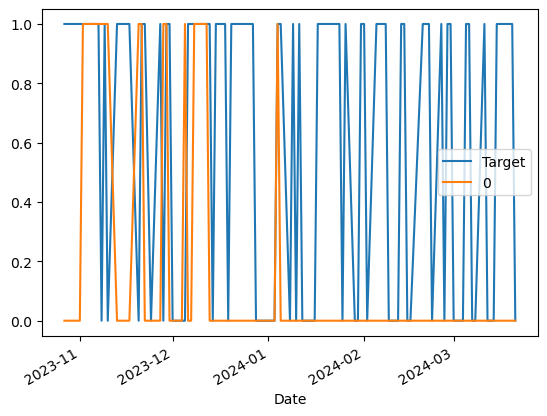

In [9]:
combined = pd.concat([test["Target"], preds], axis=1)
combined.plot()

In [22]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [23]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)


predictions = backtest(sp500, model, predictors)
predictions["Predictions"].value_counts()
precision_score(predictions["Target"], predictions["Predictions"])

0.5771971496437055

In [24]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()
    
    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    
    new_predictors+= [ratio_column, trend_column]

/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_36768/10987703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
/var/folders/vm/77fdm2ks1xz616jlwd2q7g0w0000gn/T/ipykernel_36768/10987703.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]


In [25]:
sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
sp500

,Close,Open,High,Low,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,Trend_5,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000
Date,,,,,,,,,,,,,,,,,
2012-02-29 00:00:00-05:00,1365.680054,1372.199951,1378.040039,1363.810059,4482370000,1374.089966,1,0.997626,1.0,0.999086,4.0,1.051514,39.0,1.074300,138.0,1.197112,553.0
2012-03-01 00:00:00-05:00,1374.089966,1365.900024,1376.170044,1365.900024,3919240000,1369.630005,0,1.003070,1.0,1.003677,4.0,1.056230,40.0,1.080736,139.0,1.204422,553.0
2012-03-02 00:00:00-05:00,1369.630005,1374.089966,1374.530029,1366.420044,3283490000,1364.329956,0,0.998374,1.0,0.999851,3.0,1.051286,39.0,1.077026,139.0,1.200427,553.0
2012-03-05 00:00:00-05:00,1364.329956,1369.589966,1369.589966,1359.130005,3429480000,1343.359985,0,0.998061,0.0,0.996456,2.0,1.045801,38.0,1.072715,138.0,1.195690,553.0
2012-03-06 00:00:00-05:00,1343.359985,1363.630005,1363.630005,1340.030029,4191060000,1352.630005,1,0.992255,0.0,0.985288,1.0,1.028645,37.0,1.056150,138.0,1.177299,552.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15 00:00:00-04:00,5117.089844,5123.310059,5136.859863,5104.350098,7753670000,5149.419922,1,0.996748,0.0,0.994533,1.0,1.038407,34.0,1.141730,140.0,1.257523,532.0
2024-03-18 00:00:00-04:00,5149.419922,5154.770020,5175.600098,5145.470215,4036220000,5178.509766,1,1.003149,1.0,0.999594,2.0,1.043622,34.0,1.147717,140.0,1.264685,532.0
2024-03-19 00:00:00-04:00,5178.509766,5139.089844,5180.310059,5131.589844,4031760000,5224.620117,1,1.002817,2.0,1.005114,2.0,1.047818,35.0,1.152992,140.0,1.271007,533.0


In [26]:
predictions

,Target,Predictions
Date,,
2018-02-14 00:00:00-05:00,1,1.0
2018-02-15 00:00:00-05:00,1,1.0
2018-02-16 00:00:00-05:00,0,0.0
2018-02-20 00:00:00-05:00,0,0.0
2018-02-21 00:00:00-05:00,1,1.0
...,...,...
2024-03-15 00:00:00-04:00,1,0.0
2024-03-18 00:00:00-04:00,1,0.0
2024-03-19 00:00:00-04:00,1,0.0
